# Tutorial 2 - Training and Tuning of Deep Learning Models in Python

The lecture has introduced you to foundations of neural networks. Therefore, in today's tutorial notebook we will revisit the forward pass performed in shallow and deep neural networks on tabular data. This will help us understand the functionality behind **sklearn's MLPRegressor**, as well as which hyperparameters of neural networks can be tuned to improve their performance.

Here is the outline of the notebook:
*   Forward pass of shallow and deep neural networks in numpy (Demo).
*   Implementation of two MLPRegressor models with varying depth using sklearn (Excercise 1).
*   Tuning of MLPRegressor using Optuna (Excercise 2).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

## **1. Forward Pass of shallow and deep Neural Networks with Numpy** (DEMO)

### **1.1. Forward Pass in Neural Networks with a single hidden Layer**

First, let's revisit the forward pass in a shallow neural network, using the below illustration: <br>

![Shallow Neural Network](https://github.com/Humboldt-WI/demopy/raw/main/Shallow_Neural_Network_Forward_Pass.PNG)

This is a neural network with **<em>m</em>** input variables, which are fed to a single hidden layer with **<em>w</em>** = 2 units. The hidden layer makes use of the activation function **<em>g</em>** to transform the latent representation of the inputs nonlinearly. The output of the nonlinear transformation is then fed to the final layer, i.e., the prediction layer, which produces the estimates of the target variable **<em>y</em>**.<br>

Now, imagine you have a batch of 20 samples with 5 predictor features and a single continuous target variable. You are tasked to implement the forward pass of the above-described neural network with numpy. First, we will simulate our batch of data by drawing samples from a standard normal distribution using numpy:

In [2]:
#Simulation of a batch of 20 samples with 5 features:
w=2
m=5
num_samples=20
data_batch=np.random.normal(size=m*num_samples,loc=0.0,scale=1.0).reshape(num_samples,m)
#We create an artificial target variable using the exponential function in numpy:
target=np.exp(np.dot(data_batch,np.random.normal(size=m).reshape(-1,1)))
print('Shape of batch of simulated data: ',data_batch.shape)

Shape of batch of simulated data:  (20, 5)


In [7]:
np.dot

<function dot at 0x7cad50393c70>

Next, we will initialize the trainable parameters of the hidden layer and the output layer of the shallow network. The shape of the weight matrices in the hidden layer  and the output layer are **<em>(m,w)</em>** and **<em>(w,1)</em>**. The shape of the bias weights is determined by the  number of units in each layer. Since one of the main advantages of using neural networks is their ability to approximate nonlinear relationships, we will define two nonlinear activation functions, i.e., ReLU and Tanh. We will use both to nonlinearly transform the latent feature space produced by the matrix multiplication of the network weights with the synthetic batch of data.

In [14]:
w_hidden_layer=np.random.normal(size=m*w).reshape(m,w)
bias_hidden_layer=np.random.normal(size=w)

w_output_layer=np.random.normal(size=w).reshape(-1,1)
bias_output_layer=np.random.normal(size=1)

print('Shape of the trainable weight matrices of the shallow neural network:')
print('- W of hidden layer:',w_hidden_layer.shape)
print('- Bias of hidden layer:',bias_hidden_layer.shape,'\n')
print('- W of output layer:',w_output_layer.shape)
print('- Bias of output layer:',bias_output_layer.shape,'\n')

Shape of the trainable weight matrices of the shallow neural network:
- W of hidden layer: (5, 2)
- Bias of hidden layer: (2,) 

- W of output layer: (2, 1)
- Bias of output layer: (1,) 



In [15]:
#Linear latent feature space of inputs: generated with matrix multiplication,
#we implement the latter with the function numpy.dot:
linear_latent_representation=np.dot(data_batch,w_hidden_layer) + bias_hidden_layer
print('Shape of the linear latent representation of the input variables: ',linear_latent_representation.shape)

Shape of the linear latent representation of the input variables:  (20, 2)


In [16]:
linear_latent_representation

array([[ 1.89627434, -1.06413886],
       [ 3.6897866 , -0.39801462],
       [ 0.53858035, -1.74855917],
       [ 1.60809604,  1.29915434],
       [ 2.91671824, -1.02951529],
       [ 2.89493853,  0.21551468],
       [ 1.40332723,  0.13285476],
       [ 2.75348811, -0.60078831],
       [ 0.13695321, -1.13761092],
       [ 1.48003174,  0.11549947],
       [ 1.02488363,  0.13712645],
       [ 1.65970245, -1.82478289],
       [ 1.90125946, -3.12882269],
       [ 3.05367003, -0.71072764],
       [ 1.05470851, -1.05480379],
       [ 1.50321963, -0.84333935],
       [ 2.30169662,  0.72109693],
       [ 0.48792708, -1.81690325],
       [ 1.91629114, -2.73055519],
       [ 0.77607484, -0.09578844]])

The matrix multiplication of the weights with the input variables produces a linear latent representation consisting of 2 units for each of the 20 synthetic data samples. The bias weights array has only 2 trainable weights. At first sight, the addition of one-dimensional array to a two-dimensional matrix with the shape (20,2) seems conceptually impossible in the context of linear algebra. However, due to broadcasting, numpy efficiently adds the bias weights to each row of the latent representation. For more details on broadcasting, we refer the reader to: https://numpy.org/doc/stable/user/basics.broadcasting.html. <br>

Next, we create a well-documented function implementing ReLU and Tanh:

In [17]:
def nonlinear_func(x:np.ndarray,
                   activation_name:str)->np.ndarray:
    """Computes ReLU or Tanh transformations of the inputs.

    Parameters:
    ----------
    x: np.ndarray
        The linearly transformed inputs.
    activation_name: str
        The name of the activation function, i.e., ReLU or Tanh.

    Returns:
    ----------
    nonlinear_x: np.ndarray
        The nonlinearly transformed inputs.

    Raises:
    ----------
    ValueError: If specified activation_name is not in the list [ReLU, Tanh].
    """

    if activation_name not in ['ReLU','Tanh']:
        raise ValueError(f'The currently specified activation function {activation_name} is not in the list of supported nonlinearities.')

    if activation_name=='Tanh':
        nonlinear_x=np.tanh(x)
    else:
        nonlinear_x=x*(x>0.0)

    return nonlinear_x

As you can see in the above function, we specify the type of the input parameters and the type of the output values of our function. Also, we provide a brief summary of what the function does, what the input parameters and the return value represent. Proper documentation of your functions improves the readability of your code a lot especially for someone, who is examining your code for the first time. For more details on the annotation of python functions, we refer the reader to: https://peps.python.org/pep-3107/#fundamentals-of-function-annotations. <br>

Next, we will pass the linearly weighted inputs through our nonlinear activations, and we will plot the distribution of the resulting values:

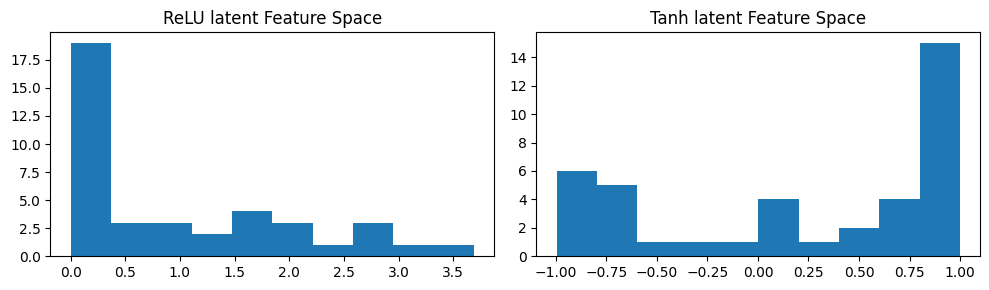

In [18]:
relu_latent=nonlinear_func(x=linear_latent_representation,activation_name='ReLU')
tanh_latent=nonlinear_func(x=linear_latent_representation,activation_name='Tanh')

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].hist(relu_latent.flatten())
ax[0].set_title('ReLU latent Feature Space')

ax[1].hist(tanh_latent.flatten())
ax[1].set_title('Tanh latent Feature Space')

fig.tight_layout()
plt.show()
plt.close()

The above histogram plots highlight the difference in the distribution of the latent features. While ReLU produces a right-skewed representation of the inputs, Tanh generates a bimodal latent feature space. Generally, the ReLU activation is prefered over Tanh in neural networks, especially in deep neural models. However, Tanh could also be applied in rather shallow neural models. The main limitation of Tanh, and generally speaking of activations with a lower and an upper bound, is that output values very close to the saturation regions, i.e., -1 and 1 in case of Tanh, receive almost no gradients in the backward pass. Therefore, bounded activation functions suffer from the vanishing gradients problem.<br>

Next, we produce the predictions of our synthetic target:  

In [19]:
relu_predictions=np.dot(relu_latent,w_output_layer)+bias_output_layer
tanh_predictions=np.dot(tanh_latent,w_output_layer)+bias_output_layer
print('Predictions shape: ',relu_predictions.shape)

Predictions shape:  (20, 1)


To evaluate the quality of the estimations, we define a function computing the mean-squared error:

In [20]:
def mse(true_target:np.ndarray,
        predictions:np.ndarray)->np.float64:
    '''
    Computes the mean-squared error (MSE) between the true values of the target variable and the predictions of an ML model.

    Parameters:
    -----------
    true_target: np.ndarray
        The true values.
    predictions: np.ndarray
        The estimation of the target values.

    Returns:
    -----------
    mse_score: np.float
        The error between the true values and the predictions measured in terms of MSE.
    '''
    mse_score=np.mean((true_target-predictions)**2)
    return mse_score

In [21]:
print('MSE from ReLU-Network: ',round(mse(true_target=target,predictions=relu_predictions),3))
print('MSE from Tanh-Network: ',round(mse(true_target=target,predictions=tanh_predictions),3))

MSE from ReLU-Network:  37.846
MSE from Tanh-Network:  34.903


So far we have performed the forward pass of a neural network with a single hidden layer. Without any training of the two versions of the neural network the results in terms of MSE seem pretty close to each other, as both versions use the same randomly initialized weights in the hidden layer. We will use our mse function in Section 2 and Section 3, where we will compare the performance of two trained neural networks and we will implement neural network tuning, respectively.

### **1.1. Forward Pass in deep Neural Networks with several hidden Layers**

Before we move on to more coding, let's recap the forward pass in deep neural networks: <br>

![Deep Neural Network](https://github.com/Humboldt-WI/demopy/raw/main/Deep_Neural_Networks_Forward_Pass.PNG)

The above visualization shows that in a deep neural network the layers are structured in a chain, where the output of each layer is fed as an input to every following layer. By "fed", we mean that we compute the matrix multiplication between the latent representation of the previous layer and the trainable weights of the current layer, add the biases and apply a nonlinear activation function. Therefore, the output shape of each hidden layer determines the shape of the weight matrices of every following hidden layer.<br>

Below, we create a function, which computes the forward pass of an arbitrarily ReLU-based deep neural network implemented in numpy:

In [22]:
def deep_neural_net(hidden_units:list,
                    inputs:np.ndarray,
                    print_layer_shape:bool)->np.ndarray:
    '''
    Computes the forward pass with an arbitrarily deep feedforward neural network.

    Parameters:
    -----------
    hidden_units: list
        A list of hidden units, which also determines the number of hidden layers in the network.
    inputs: np.ndarray
        A two-dimensional numpy matrix containing the data samples in the rows, and the predictor variables in the columns.
    print_layer_shape: bool
        Determines whether to print the shape of the latent representation produced by each hidden layer and the final prediction layer.

    Returns:
    -----------
    predictions: np.ndarray
        The estimation of the target.
    '''

    current_linear_representation=inputs.copy()
    if print_layer_shape==True:
        print('Inputs shape: ',inputs.shape,'\n')


    for nr_units_idx in range(0,len(hidden_units)):
        if nr_units_idx==0:
            current_weights=np.random.normal(size=inputs.shape[1]*hidden_units[nr_units_idx]).reshape(inputs.shape[1],hidden_units[nr_units_idx])
        else:
            current_weights=np.random.normal(size=previous_matrix_shape[1]*hidden_units[nr_units_idx]).reshape(previous_matrix_shape[1],hidden_units[nr_units_idx])
        current_bias_weights=np.random.normal(size=hidden_units[nr_units_idx])

        #At each hidden layer we overwrite the linear representation passed to the nonlinearity:
        current_linear_representation=np.dot(current_linear_representation,current_weights)+current_bias_weights

        #ReLU-based transformation:
        current_nonlinear_representation=nonlinear_func(x=current_linear_representation,
                                                        activation_name='ReLU')
        previous_matrix_shape=current_weights.shape

        if print_layer_shape==True:
            print('Output shape of ',(nr_units_idx+1),'.hidden layer: ',current_nonlinear_representation.shape,'\n')

    #Compute the predictions:
    output_layer_weights=np.random.normal(size=current_nonlinear_representation.shape[1]).reshape(-1,1)
    bias_output_layer=np.random.normal(size=1).reshape(-1,1)

    predictions=np.dot(current_nonlinear_representation,output_layer_weights)+bias_output_layer
    if print_layer_shape==True:
        print('Output shape of prediction layer: ',predictions.shape,'\n')
    return predictions

In [23]:
predictions_deep_net=deep_neural_net(hidden_units=[100,50,10],
                                     inputs=data_batch,
                                     print_layer_shape=True)

Inputs shape:  (20, 5) 

Output shape of  1 .hidden layer:  (20, 100) 

Output shape of  2 .hidden layer:  (20, 50) 

Output shape of  3 .hidden layer:  (20, 10) 

Output shape of prediction layer:  (20, 1) 



## **2. Implementation of deep feed-forward regression neural networks using sklearn.** <br>(Excercise 1)

In this section, first, we will import a house pricing dataset from tensorflow, i.e., boston housing dataset. Afterward, we will examine some basic statistical characteristics of the features. Once the data is rescaled, we will train an MLPRegressor from sklearn to forecast the median price values of boston houses (our target variable).

In [75]:
# this will import and split the data 80-20% by default:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

print('Shape of train data:',x_train.shape,
'\nShape of test data:', x_test.shape)

Shape of train data: (404, 13) 
Shape of test data: (102, 13)


The descriptions of the features are the following (more details about this dataset can be found in [http://lib.stat.cmu.edu/datasets/boston](http://lib.stat.cmu.edu/datasets/boston))<br>
| # | Variable | Description |
|---|---|---|
| 1 | CRIM | per capita crime rate by town |
| 2 | ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| 3 | INDUS | proportion of non-retail business acres per town |
| 4 | CHAS | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| 5 | NOX | nitric oxides concentration (parts per 10 million) |
| 6 | RM | average number of rooms per dwelling |
| 7 | AGE | proportion of owner-occupied units built prior to 1940 |
| 8 | DIS | weighted distances to five Boston employment centres |
| 9 | RAD | index of accessibility to radial highways |
| 10 | TAX | full-value property-tax rate per $10,000 |
| 11 | PTRATIO | pupil-teacher ratio by town |
| 12 | B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| 13 | LSTAT | % lower status of the population |

So, we have 404 samples to train and 102 to test, each with 13 numerical features. The target is the median values of homes. Let's have a quick look at the predictor features:

In [77]:
pd.DataFrame(x_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


In [78]:
pd.DataFrame(x_train).isna().sum().sum()

np.int64(0)

The desriptive statistics show that the is a big variation in the mean and the standard deviation of the predictor variables. This indicates that the input features have different scales. For this reason, we will standardize our test dataset based on the statistics computed on the rescaled train dataset. With data rescaling, we ensure that no predictor dominates the input feature space due to varying variable scale. This, in turn, improves the stability of the training process, and facilitates faster convergence. The StandardScaler can be imported from sklearn.preprocessing: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html. Take a look at the code example provided under the link, and standardize the boston housing dataset:

In [79]:
from sklearn.preprocessing import StandardScaler

#Data rescaling:

StandardScaler.fit(StandardScaler(),x_train)        #Should always put its self as the first argument in Standard Scalar

#Creating a new rescaled data set with standardscalar
x_train_rescaled = StandardScaler.fit_transform(StandardScaler(),x_train)
print(pd.DataFrame(x_train_rescaled))

#Visualization of real x_train values in tabular format
print(pd.DataFrame(x_train))

           0         1         2         3         4         5         6   \
0   -0.272246 -0.483615 -0.435762 -0.256833 -0.165227 -0.176443  0.813062   
1   -0.403427  2.991784 -1.333912 -0.256833 -1.215182  1.894346 -1.910361   
2    0.124940 -0.483615  1.028326 -0.256833  0.628642 -1.829688  1.110488   
3   -0.401494 -0.483615 -0.869402 -0.256833 -0.361560 -0.324558 -1.236672   
4   -0.005634 -0.483615  1.028326 -0.256833  1.328612  0.153642  0.694808   
..        ...       ...       ...       ...       ...       ...       ...   
399 -0.381973 -0.483615 -0.616568 -0.256833 -0.933487 -0.938177 -0.251223   
400 -0.388221  0.358906 -0.609218 -0.256833 -0.796907 -0.038202 -1.888860   
401 -0.402030  0.990797 -0.741515 -0.256833 -1.019702 -0.333021 -1.638018   
402 -0.172920 -0.483615  1.245881 -0.256833  2.677335 -0.787241  1.056737   
403 -0.404226  2.043948 -1.201615 -0.256833 -1.334689  0.475263 -1.799274   

           7         8         9         10        11        12  
0    0.11

Next, we plot the distribution of the target variable on the train set, and examine whether it is also necessary to standardize the target in addition to the predictor variables:

mean of train values:  0    22.39505
dtype: float64


,0
count,404.000000
mean,22.395050
std,9.210442
min,5.000000
25%,16.675000
50%,20.750000
75%,24.800000
max,50.000000


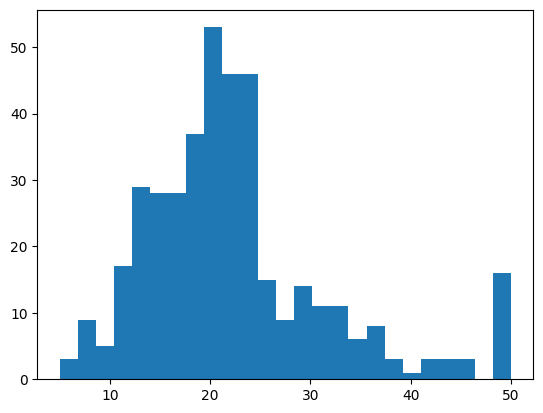

In [87]:
#Plotting the distribution of target train values with a histogram from matplotlib.pyplot (imported as plt):
plt.hist(y_train, bins=25)
print('mean of train values: ', pd.DataFrame(y_train).mean())

pd.DataFrame(y_train).describe()

Now that we are completely done with the data preprocessing, we move on to training MLPRegressor() from sklearn.neural_network: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html. After examining the possible hyperparameters, which can be specified in MLPRegressor(), we will train two neural models. The latter should use the Adam optimizer with the learning rate=0.001. Additionally, the first neural network should have a single Tanh-based hidden layer with 10 units, while the second network should apply ReLU in two hidden layers with the number of units [10,5]. Once the training process is complete, we will compare the performance of the two models on the test set using MSE. We defined the latter in a function in the first part of the notebook (the demo showing the forward passes). If you re-run the models several times, do you observe differences in the results? If yes, then why?

In [104]:
from sklearn.neural_network import MLPRegressor

#Your implementation of the MLPRegressors:
tanh_MLP= MLPRegressor(hidden_layer_sizes=(10),
                       activation='tanh',
                       solver='adam',
                       learning_rate_init=0.001)
relu_MLP=MLPRegressor(hidden_layer_sizes=(10,5),
                      activation='relu',
                      solver='adam',
                      learning_rate_init=0.001)

tanh_MLP.fit(x_train_rescaled,y_train)
relu_MLP.fit(x_train_rescaled,y_train)

scaler=StandardScaler()
scaler.fit(x_test)
x_test_rescaled = scaler.transform(x_test)

print(np.mean((tanh_MLP.predict(x_test_rescaled)-y_test)**2))
print(np.mean((relu_MLP.predict(x_test_rescaled)-y_test)**2))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


386.2390277395615
53.975379292900044


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## **3. Hyperparameter Tuning using Optuna.** <br>(Excercise 2)

Optuna represents an automatic hyperparameter optimization software framework, which supports multiple samplers, including the Tree-Parzen Estimator (TPE). This name implies a tree-structured search space, i.e., a search space that includes some conditional parameters, and use Parzen estimators such as kernel density estimators (KDEs). In a nutshell, TPE models the probability distribution of good and bad hyperparameter configurations, and then uses that to guide the search, i.e., to achieve a balance between exploration (trying new areas) and exploitation (focusing on promising regions).<br>

Before we move on with the encoding of the search space using optuna, take a look at some code examples under the link: https://optuna.org/#code_examples. The hyperparameter tuning with optuna consists mainly of 5 aspects:
- the definition of an objective function, which encodes the potentially conditional search space.
- the creation of a study with optuna using a specific sampler, e.g., TPE. The study object should also  <br>
  receive the direction for the optimization of the chosen metric, i.e., maximize accuracy or minimize an error metric.
- the optimization of the hyperparameters for a pre-defined number of trials based on a score computed on the validation set.
- extraction of the best hyperparameter configuration, and application of the best performing model on the test set.

Next, we will reserve the last 104 samples from our train dataset for validation purposes, and we will define the following search space in Optuna's objective function:
- for a maximum of 3 hidden layers sample values in [10,200] with stepsize=10. For deeper hidden layers allow optuna to sample also 0 units, indicating the network is not grown deeper.
- Optimizer: ['adam','sgd']
- Learning_Rate: [0.0001,0.001] with stepsize=0.0001
- Activation=['identity', 'logistic', 'tanh', 'relu']

Additionally, the alpha parameter, i.e., the L2 regularization coefficient, is set to the rather high value of 0.01 during the tuning process to avoid overfitting.

In [ ]:
import optuna

#We reserve 104 samples from our training dataset for validation purposes. We should rescale the new
#train and validation subsets:
x_train_optuna,x_val_optuna=...
y_train_optuna,y_val_optuna=...

#We rescale the new train and validation subsets:

x_train_optuna_rescaled=...
x_val_optuna_rescaled=...



The main structure of the objective function is already defined. Therefore, you would have to fill in the missing code in order to create the search space. If the code runs error free, you should be able to execute the optimization (two cells below the current cell, where we call study.optimize). The comments in the objective function highlight the functionality that has to be implemented:

In [ ]:
#Definition of the objective as python function:

def objective(trial: optuna.Trial) -> np.float64:
    '''
    Perform hyperparameter tuning using optuna.

    Parameters:
    -----------
    trial:optuna.Trial
        An optuna run with a specific hyperparameter configuration sampled in this function.

    Returns:
    ---------
    mse_val: np.float64
        The mse error score achieved on the validation set.
    '''

    #Sample number of neurons for a pre-defined maximum number of hidden layers:
    # here you need to consider conditional hyperparameters:
    max_hidden_layers=3
    hidden_units_list=[]
    keep_sampling_hidden_units=True
    nr_hidden_layer=0

    #Keep on sampling the number of hidden units until you have reached the max number of layers
    #or until optuna has sampled 0 units indicating the network should not be grown deeper:
    while keep_sampling_hidden_units:
        if nr_hidden_layer==0:
            current_hidden_units=trial.suggest_int("Units_hidden_layer_"+str(nr_hidden_layer), low=10, high=200,step=10)
        else:
            current_hidden_units=...

        #Terminate the training if max number of layers reached or currently sampled units are 0:
        ...

        #Save the sampled number of units in the list hidden_units_list unless optuna has sampled 0 units:
        ...


        nr_hidden_layer=nr_hidden_layer+1

    #Non-conditional hyperparameters:
    current_optimizer=...
    current_learning_rate=...
    current_activation=...

    #Implementation of an MLPRegressor using the hyperparameters sampled in the current trial.
    #Don't forget to also set the L2 parameter to a rather high value, e.g., 0.01, to avoid overfitting:
    current_MLP_regressor=...

    #Fit on the training set and evaluate the performance on validation set:
    current_MLP_regressor.fit(x_train_optuna_rescaled,y_train_optuna)
    val_predictions=current_MLP_regressor.predict(x_val_optuna_rescaled)

    mse_val=...
    return mse_val

In [ ]:
#Hyperparameter optimization using Optuna for 50 trials:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction='minimize')
study.optimize(objective, n_trials=50)

In [ ]:
#Extraction of best hyperparameters and application of the model trained with the best configuration on the test set:
best_config=study.best_trial.params
print('Best configuration:')
for key in best_config.keys():
    print(key,': ',(best_config[key]))

In [ ]:
#Implementation of the MLP-regressor with the best hyperparameter configuration:
best_mlp_regressor=...

best_mlp_regressor.fit(x_train_rescaled,y_train)

In [ ]:
#Comparison of results with tuned vs not tuned ReLU-neural network:
